In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

import math
import os

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

from RW_NN_ext import IQ_gen_NN, IQ_gen_NN_cpu

tensorflow version = 2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5613556933208423280
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13254587219990044387
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                           

## pyvista visualization

In [3]:
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

#### Wave vector distribution ####
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi_r) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def std_phi(kappa):
    xi_list = np.linspace(1/10000,1,10000)
    W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
    phi = np.arccos(W)
    sigma = np.sqrt(np.sum(phi**2*np.sin(phi))/np.sum(np.sin(phi)))/np.pi*180
    return sigma

In [4]:
def clip_random_wave(fp_opt, W=100):
    ### Clipping random wave ####
    k_mean = np.array([0,0,20])*np.pi
    k_var  = (np.array([0,0,fp_opt['sigma_k']])*np.pi)**2 # k_z
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean/4,k_cov/4,n_wave = 100, kappa = fp_opt['kappa']) # kappa

    alpha = fp_opt['alpha'] # alpha

    ### pyvista ###
    import pyvista as pv
    pv.set_jupyter_backend('trame')
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho.flatten('F')
    mesh = grid.contour([alpha])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    backface_params = dict(color='#303030',
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
    #                        opacity=0.5
                        )
    pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params, 
                smooth_shading=True, 
    #             opacity=0.5
                )

    # camera setting
    pl.camera_position = 'yz'
    # pl.camera.azimuth = -60.0
    # pl.camera.elevation = 24.0
    pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    path = './Figures/'
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print('new directory created')

    filename = path+'AOT_{:0.4f}.png'.format(W)
    pl.show(screenshot=filename)

In [5]:
def curvature(fp_opt, W=100):
    ### Clipping random wave ####
    k_mean = np.array([0,0,20])*np.pi
    k_var  = (np.array([0,0,fp_opt['sigma_k']])*np.pi)**2 # k_z
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean/4,k_cov/4,n_wave = 100, kappa = fp_opt['kappa']) # kappa

    alpha = fp_opt['alpha'] # alpha

    ### pyvista ###
    import pyvista as pv
    pv.set_jupyter_backend('trame')
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho.flatten('F')
    mesh = grid.contour([alpha])

    # curvature
    MC = mesh.curvature(curv_type='mean', progress_bar=True)
    GC = mesh.curvature(curv_type="gaussian", progress_bar=True)
    cell_sizes = mesh.compute_cell_sizes(length=False)

    return MC, GC, cell_sizes

## load experimental data

In [6]:
W_list = [30,40,50]
## load D22 data
n_des = 1
data_path = '../Data/AOT-DesmearedData/'
data_list = []
for W in W_list:
    filename = '{}_des{}.txt'.format(W,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

In [7]:
def unpack_data(data):
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    return Q, IQ, IQ_er

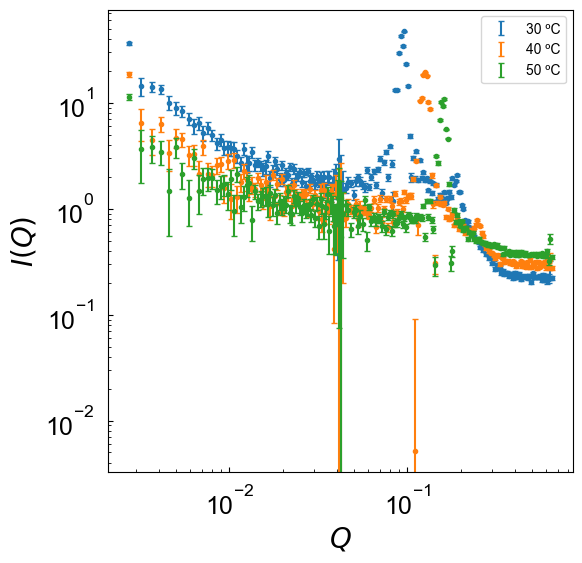

In [8]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    dataname = '{} ºC'.format(W)
    Q, IQ, IQ_er = unpack_data(data)
    ax.plot(Q,IQ,'.', color = colors[i_W])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i_W] ,capsize=2)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()

max_Q = 0.64574395
0.09617666
0.004973010330889917
0.12554282
0.005380808936813805
0.16140872
0.007268533862772769


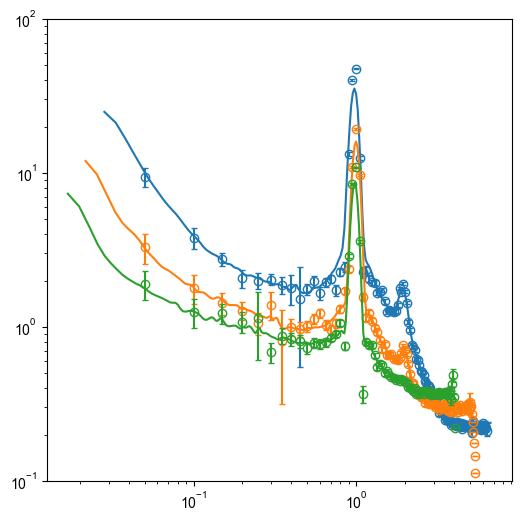

In [9]:
IQ_list = []
IQ_er_list = []
Q_max_list = []
max_Q = Q[-1]
print('max_Q = {}'.format(max_Q))
delta_Q_list = []

box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    Q, IQ, IQ_er = unpack_data(data)

    # ## trim low Q
    # index_Q = Q_in>7e-3
    # Q = Q_in[index_Q]
    # IQ = IQ_in[index_Q]
    # IQ_err = IQ_err_in[index_Q]

    # ## extend low Q
    # index_low_Q = Q<3.5e-2
    # Q_low_Q = Q[index_low_Q]
    # IQ_low_Q = IQ[index_low_Q]
    # coeff = np.polyfit(Q_low_Q, IQ_low_Q, 2)
    # p = np.poly1d(coeff)
    # IQ[index_low_Q] = p(Q_low_Q)

    # ## substrate background
    # index_high_Q = Q>5e-1
    # IQ_high_Q = IQ[index_high_Q]
    # I_bg = np.median(IQ_high_Q)
    # IQ = IQ - I_bg

    # ## substrate low-Q
    # A_4 = IQ[0]/Q[0]**(-4)
    # IQ_4 = A_4*Q**(-4)
    # IQ = IQ - IQ_4*0

    # ## extend high Q
    # index_high_Q = (Q>2e-1)
    # index_high_Q_fit = (Q>2e-1)*(Q<3e-1)
    # Q_high_Q = Q[index_high_Q_fit]
    # IQ_high_Q = IQ[index_high_Q_fit]
    # coeff = np.polyfit(Q_high_Q, np.log(IQ_high_Q), 2)
    # p = np.poly1d(coeff)
    # IQ[index_high_Q] = np.exp(p(Q[index_high_Q]))

    ## peak_position
    index_peak_range = Q>4e-2
    Q_peak_range = Q[index_peak_range]
    IQ_peak_range = IQ[index_peak_range]

    index_Q_max = np.argmax(IQ_peak_range)
    Q_max = Q_peak_range[index_Q_max]
    print(Q_max)
    Q_max_list.append(Q_max)
    Q_rs = Q/Q_max*np.pi*20

    Q_d_err = Q_peak_range[(index_Q_max-5):(index_Q_max+5)]
    IQ_d_err = IQ_peak_range[(index_Q_max-5):(index_Q_max+5)]
    delta_Q = np.sqrt(np.sum(IQ_d_err*(Q_d_err-Q_max)**2)/np.sum(IQ_d_err))
    delta_Q_list.append(delta_Q)
    print(delta_Q)

    f_interp = interp.interp1d(Q_rs, IQ, kind='linear',fill_value='extrapolate')
    IQ_interp = f_interp(qq)
    IQ_interp[IQ_interp<0] = 1e-2

    f_interp_er = interp.interp1d(Q_rs, IQ_er, kind='linear',fill_value='extrapolate')
    IQ_er_interp = f_interp_er(qq)
    IQ_er_interp[IQ_er_interp<0] = 0

    IQ_list.append(IQ_interp)
    IQ_er_list.append(IQ_er_interp)

    # ## interpolate resolution
    # f_interp = interp.interp1d(Q_rs, Q_err_in, kind='linear',fill_value='extrapolate')
    # Q_err_interp = f_interp(qq)/Q_max*np.pi*20
    # Q_err_list.append(Q_err_interp)

    ax.plot(qq/(np.pi*20), IQ_interp, 'o', label=data[0], color=colors[i_W], fillstyle='none')
    ax.errorbar(qq/(np.pi*20), IQ_interp, IQ_er_interp,linestyle='',label=dataname, color = colors[i_W] ,capsize=2)
    ax.plot(Q/Q_max, gaussian_filter(IQ,1.5), '-', color=colors[i_W])
    # ax.plot(qq[5:], Q_err_interp[5:], '.-', label=data[0])
    # ax.plot(Q_high_Q, IQ[index_high_Q], '.', label=data[0])
    # ax.plot(Q,IQ)

IQ_list = np.array(IQ_list)
IQ_er_list = np.array(IQ_er_list)

ax.set_ylim([1e-1,1e2])

ax.set_yscale('log')
ax.set_xscale('log')

In [10]:
from scipy.special import erf
def volume_fraction(alpha):
    '''
    Evaluate the fraction of water given clipping level alpha
    '''
    return 1-(1+erf(alpha/np.sqrt(2)))/2


## Fit the data

In [11]:
result_list = []

### 30%

In [12]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data,1:-1]
IQ_er_data = IQ_er_list[index_data,1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.23, min=0.05, max=1.0)
params.add('kappa', value=4, min=1, max=12)
params.add('alpha', value=0.7, min=0.5, max=1.0)
params.add('y_scale', value=6.3e5, min=1e5, max=1e6)
params.add('x_scale', value=1.05, min=0.9, max=1.1)
params.add('bg', value=0.2, min=0.1, max=0.25)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['sigma_k'],v['kappa'],v['alpha']]
    log_IQ_NN = np.log(IQ_gen_NN(fp))
    log_IQ_NN = gaussian_filter(log_IQ_NN,1)
    Q_scaled = Q*v['x_scale']
    f_interp = interp.interp1d(Q_scaled, log_IQ_NN, kind='cubic', fill_value='extrapolate')
    IQ_scaled = np.exp(f_interp(Q))
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('nelder')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1034
    # data points      = 65
    # variables        = 6
    chi-square         = 2914.93688
    reduced chi-square = 49.4057098
    Akaike info crit   = 259.209051
    Bayesian info crit = 272.255375
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.13452923 (init = 0.23)
    kappa:    3.78274732 (init = 4)
    alpha:    0.70265696 (init = 0.7)
    y_scale:  656706.963 (init = 630000)
    x_scale:  1.01061804 (init = 1.05)
    bg:       0.20129502 (init = 0.2)
volume_fraction = 0.24113477691488971


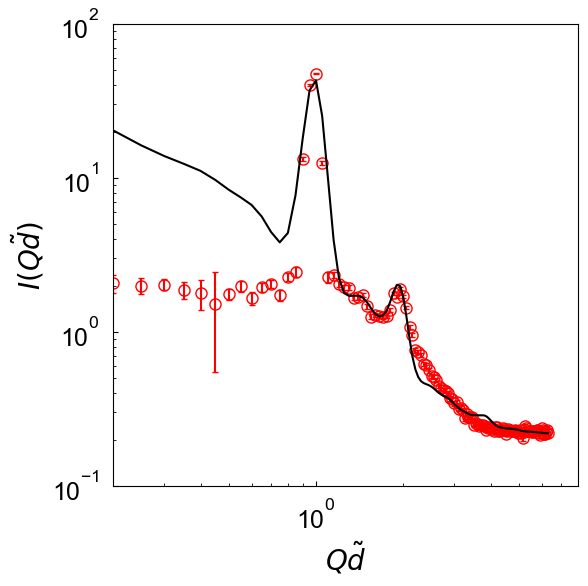

In [13]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data,1:-1]
IQ_er_data = IQ_er_list[index_data,1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4)
result = result_list[index_data]
## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<10)
qq_plot = qq_data[index_plot]/np.pi/20
IQ_plot = IQ_data[index_plot]
IQ_er_plot = IQ_er_data[index_plot]
ax.plot(qq_plot,IQ_plot,'or',fillstyle='none',ms=8)
ax.errorbar(qq_plot,IQ_plot,IQ_er_plot,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(result.params,qq_data)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

### 40%

In [14]:
# fitting targets
index_data = 1
IQ_data = IQ_list[index_data,1:-1]
IQ_er_data = IQ_er_list[index_data,1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.23, min=0.05, max=1.0)
params.add('kappa', value=3.38, min=2, max=12)
params.add('alpha', value=0.5, min=0.25, max=1.0)
params.add('y_scale', value=3e5, min=2e5, max=1e6)
params.add('x_scale', value=1.05, min=0.9, max=1.1)
params.add('bg', value=0.25, min=0.1, max=0.5)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['sigma_k'],v['kappa'],v['alpha']]
    log_IQ_NN = np.log(IQ_gen_NN(fp))
    log_IQ_NN = gaussian_filter(log_IQ_NN,1)
    Q_scaled = Q*v['x_scale']
    f_interp = interp.interp1d(Q_scaled, log_IQ_NN, kind='cubic', fill_value='extrapolate')
    IQ_scaled = np.exp(f_interp(Q))
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 687
    # data points      = 65
    # variables        = 6
    chi-square         = 1370.60097
    reduced chi-square = 23.2305249
    Akaike info crit   = 210.160126
    Bayesian info crit = 223.206449
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.15593612 (init = 0.23)
    kappa:    2.65460529 (init = 3.38)
    alpha:    0.49261749 (init = 0.5)
    y_scale:  314080.994 (init = 300000)
    x_scale:  1.02244784 (init = 1.05)
    bg:       0.27416820 (init = 0.25)
volume_fraction = 0.3111414422429759


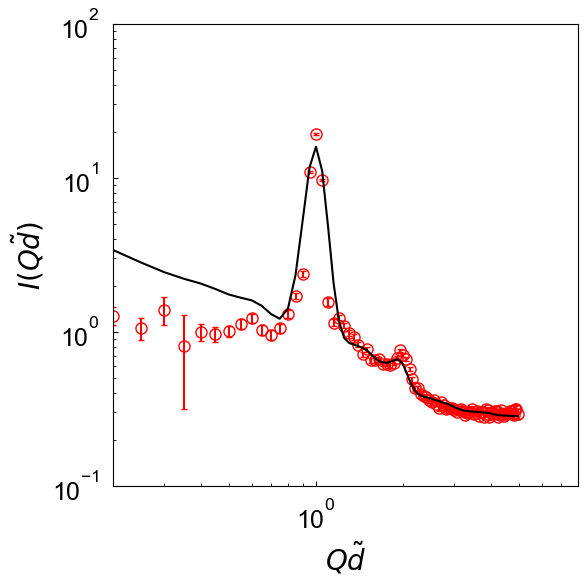

In [15]:
# fitting targets
index_data = 1
IQ_data = IQ_list[index_data,1:-1]
IQ_er_data = IQ_er_list[index_data,1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4)
result = result_list[index_data]

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<5)
qq_plot = qq_data[index_plot]/np.pi/20
IQ_plot = IQ_data[index_plot]
IQ_er_plot = IQ_er_data[index_plot]
ax.plot(qq_plot,IQ_plot,'or',fillstyle='none',ms=8)
ax.errorbar(qq_plot,IQ_plot,IQ_er_plot,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(result.params,qq_data)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

### 50%

In [16]:
# fitting targets
index_data = 2
IQ_data = IQ_list[index_data,1:-1]
IQ_er_data = IQ_er_list[index_data,1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.5)*(qq_data/np.pi/20<3)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.23, min=0.05, max=1.0)
params.add('kappa', value=1.63, min=1, max=2)
params.add('alpha', value=0.26, min=0.0, max=1.0)
params.add('y_scale', value=2.4e5, min=2e5, max=1e6)
params.add('x_scale', value=1.0, min=0.9, max=1.1)
params.add('bg', value=0.33, min=0.25, max=0.45)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['sigma_k'],v['kappa'],v['alpha']]
    log_IQ_NN = np.log(IQ_gen_NN(fp))
    log_IQ_NN = gaussian_filter(log_IQ_NN,1)
    Q_scaled = Q*v['x_scale']
    f_interp = interp.interp1d(Q_scaled, log_IQ_NN, kind='cubic', fill_value='extrapolate')
    IQ_scaled = np.exp(f_interp(Q))
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1292
    # data points      = 50
    # variables        = 6
    chi-square         = 1151.87937
    reduced chi-square = 26.1790765
    Akaike info crit   = 168.856356
    Bayesian info crit = 180.328494
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.05119077 (init = 0.23)
    kappa:    1.65898147 (init = 1.63)
    alpha:    0.29917186 (init = 0.26)
    y_scale:  242405.469 (init = 240000)
    x_scale:  1.00030909 (init = 1)
    bg:       0.32283969 (init = 0.33)
volume_fraction = 0.38240445943360424


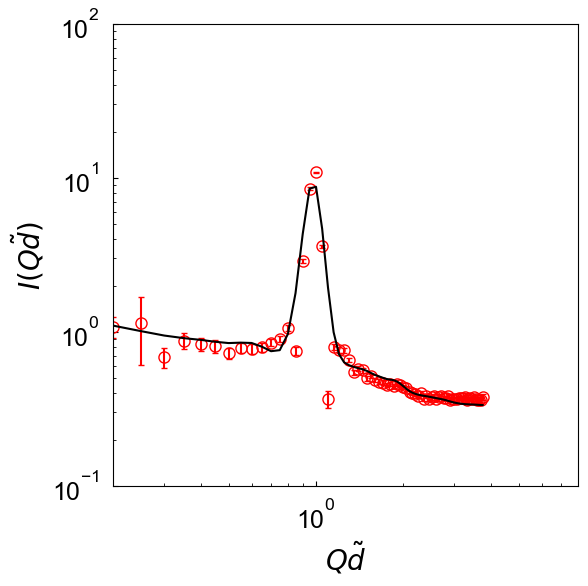

In [17]:
# fitting targets
index_data = 2
IQ_data = IQ_list[index_data,1:-1]
IQ_er_data = IQ_er_list[index_data,1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.5)*(qq_data/np.pi/20<3)
result = result_list[index_data]

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<3.8)
qq_plot = qq_data[index_plot]/np.pi/20
IQ_plot = IQ_data[index_plot]
IQ_er_plot = IQ_er_data[index_plot]
ax.plot(qq_plot,IQ_plot,'or',fillstyle='none',ms=8)
ax.errorbar(qq_plot,IQ_plot,IQ_er_plot,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(result.params,qq_data)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

## plot all fitted results


C:\Users\wagen\AppData\Local\Temp\ipykernel_39560\816518479.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(qq_plot,IQ_plot*10**(index_data*2),


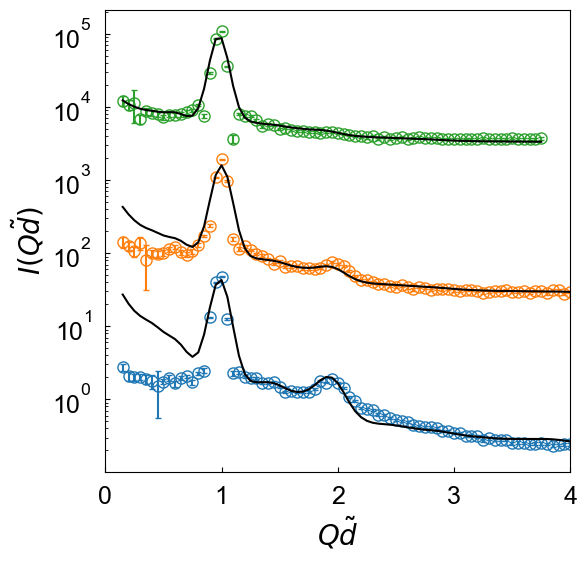

In [18]:
color_list = ['C0','C1','C2','C3','C4']

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_Q_list = [(qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4),
                (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4),
                (qq_data/np.pi/20>0.5)*(qq_data/np.pi/20<3)]

index_plot_list = [(qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<10),
                   (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<5),
                   (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<3.8)]

for index_data in range(3):
    IQ_data = IQ_list[index_data,1:-1]
    IQ_er_data = IQ_er_list[index_data,1:-1]
    qq_data = qq[1:-1]
    index_Q = (qq_data/np.pi/20>0.5)*(qq_data/np.pi/20<3)
    result = result_list[index_data]

    ## plot fitting results
    index_plot = index_plot_list[index_data]
    qq_plot = qq_data[index_plot]/np.pi/20
    IQ_plot = IQ_data[index_plot]
    IQ_er_plot = IQ_er_data[index_plot]
    ax.plot(qq_plot,IQ_plot*10**(index_data*2),
            'or',fillstyle='none',ms=8, color = color_list[index_data])
    ax.errorbar(qq_plot,IQ_plot*10**(index_data*2),IQ_er_plot*10**(index_data*2),
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
    # ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
    ax.plot(qq_data[index_plot]/np.pi/20,
            IQ_th(result.params,qq_data)[index_plot]*10**(index_data*2),'k-')

    ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
    ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlim([0,4])
    # ax.set_ylim([0.1,100])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)



C:\Users\wagen\AppData\Local\Temp\ipykernel_39560\2486275023.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(qq_plot,IQ_plot,


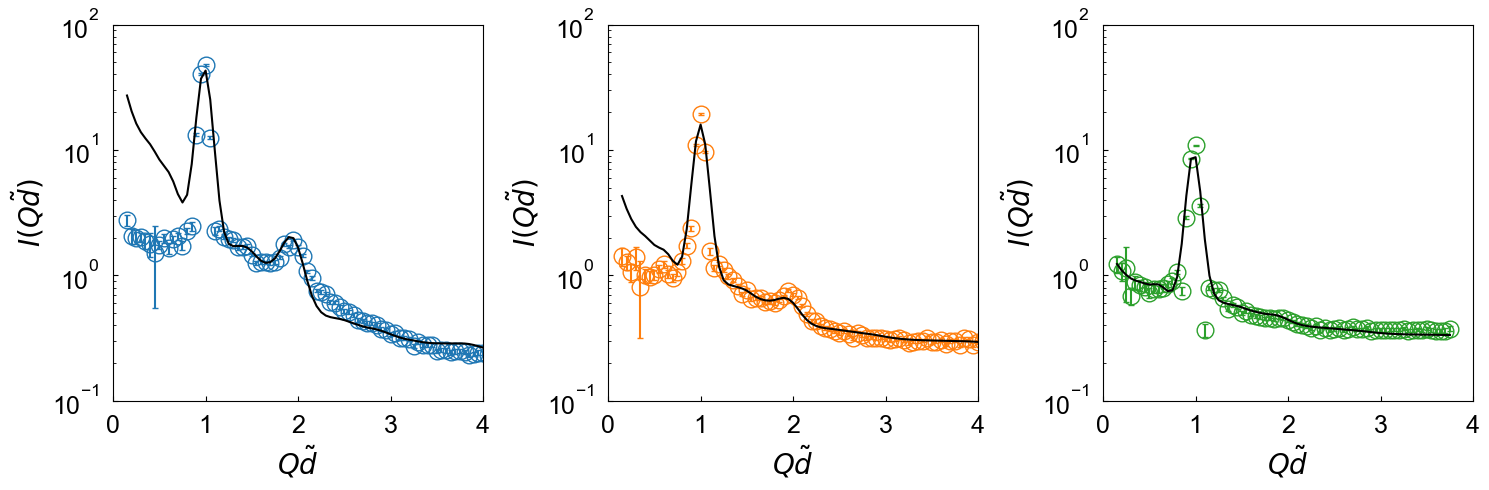

In [19]:
color_list = ['C0','C1','C2','C3','C4']

fig = plt.figure(figsize=(15,5))

index_Q_list = [(qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4),
                (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<4),
                (qq_data/np.pi/20>0.5)*(qq_data/np.pi/20<3)]

index_plot_list = [(qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<10),
                   (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<5),
                   (qq_data/np.pi/20>0.1)*(qq_data/np.pi/20<3.8)]

for index_data in range(3):
    ax = fig.add_subplot(1,3,index_data+1)
    IQ_data = IQ_list[index_data,1:-1]
    IQ_er_data = IQ_er_list[index_data,1:-1]
    qq_data = qq[1:-1]
    index_Q = (qq_data/np.pi/20>0.5)*(qq_data/np.pi/20<3)
    result = result_list[index_data]

    ## plot fitting results
    index_plot = index_plot_list[index_data]
    qq_plot = qq_data[index_plot]/np.pi/20
    IQ_plot = IQ_data[index_plot]
    IQ_er_plot = IQ_er_data[index_plot]
    ax.plot(qq_plot,IQ_plot,
            'or',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(qq_plot,IQ_plot,IQ_er_plot,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
    # ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
    ax.plot(qq_data[index_plot]/np.pi/20,
            IQ_th(result.params,qq_data)[index_plot],'k-')

    ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
    ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlim([0,4])
    ax.set_ylim([0.1,100])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()


## evaluate uncertainty

In [20]:
## evaluate uncertainty
def cov_fp(params, IQ, IQ_er, index_Q):
    v = params.valuesdict()
    delta = 0.05
    x_list = 1 + np.linspace(-5,5,7)*delta
    sigma_k_list = x_list*v['sigma_k']
    kappa_list = x_list*v['kappa']
    alpha_list = x_list*v['alpha']
    fp_center = [v['sigma_k'],v['kappa'],v['alpha']]
    sigma_k_grid, kappa_grid, alpha_grid = np.meshgrid(sigma_k_list, kappa_list, alpha_list)
    sigma_k_flat = sigma_k_grid.flatten(order='C')
    kappa_flat = kappa_grid.flatten(order='C')
    alpha_flat = alpha_grid.flatten(order='C')
    fp_flat_list = [sigma_k_flat,kappa_flat,alpha_flat]

    Q = qq_data

    ## define loss
    def IQ_th(params, Q):
        fp = [v['sigma_k'],v['kappa'],v['alpha']]
        log_IQ_NN = np.log(IQ_gen_NN(fp))
        log_IQ_NN = gaussian_filter(log_IQ_NN,1)
        Q_scaled = Q*v['x_scale']
        f_interp = interp.interp1d(Q_scaled, log_IQ_NN, kind='cubic', fill_value='extrapolate')
        IQ_scaled = np.exp(f_interp(Q))
        return IQ_scaled*v['y_scale']+v['bg']

    # calculate likelihood
    likelihood_flat = np.zeros_like(sigma_k_flat)
    for i in np.arange(len(sigma_k_flat)):
        index = np.unravel_index(i, sigma_k_grid.shape)
        fp = [sigma_k_flat[i], kappa_flat[i], alpha_flat[i]]
        IQ = IQ_th(params, Q)
        minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/z)**2))
        likelihood_flat[i] = minimizer_target(IQ[index_Q],IQ[index_Q],IQ_er[index_Q])

    # calculate covariance matrix
    cov = np.zeros([3,3])
    for m in range(3):
        for n in range(3):
            d_m = fp_flat_list[m]-fp_center[m]
            d_n = fp_flat_list[n]-fp_center[n]
            cov[m,n] = np.sum(likelihood_flat*d_m*d_n)/np.sum(likelihood_flat)

    return cov

In [21]:
std_list = []
for index_data in range(3):
    IQ_data = IQ_list[index_data,1:-1]
    IQ_er_data = IQ_er_list[index_data,1:-1]
    index_Q = index_Q_list[index_data]
    result = result_list[index_data]
    params = result.params

    cov = cov_fp(params, IQ_data, IQ_er_data, index_Q)
    std = np.sqrt(np.diag(cov))
    print(std)
    std_list.append(std)

[0.02242154 0.63045789 0.11710949]
[0.02598935 0.44243422 0.08210292]
[0.0085318  0.27649691 0.04986198]


In [22]:
def volume_fraction_err(alpha, err_alpha):
    delta = 1e-4
    almha_mi = alpha*(1-delta)
    almha_pl = alpha*(1+delta)
    vf_mi = volume_fraction(almha_mi)
    vf_pl = volume_fraction(almha_pl)
    
    err_vf = np.abs(err_alpha*(vf_pl-vf_mi)/(almha_pl-almha_mi))

    return(err_vf)

## print fitting results

In [23]:
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    d_max_err = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])
    print('{}%'.format(W_list[index_data]))
    print('d = {:0.4f} +- {:0.4f}'.format(d_max,d_max_err))
    print('sigma_k = {:0.4f}% +- {:0.4f}%'.format(v_res['sigma_k']/20*100,std_list[index_data][0]/20*100))
    print('kappa = {:0.4f} +- {:0.4f}'.format(v_res['kappa'],std_list[index_data][1]))
    print('alpha = {:0.4f} +- {:0.4f}'.format(v_res['alpha'],std_list[index_data][2]))
    print('f_AOT = {:0.4f}% +- {:0.4f}%'.format(volume_fraction(v_res['alpha'])*100,
                                                volume_fraction_err(v_res['alpha'],std_list[index_data][2])*100))

    print('\n')

30%
d = 64.6432 +- 3.3425
sigma_k = 0.6726% +- 0.1121%
kappa = 3.7827 +- 0.6305
alpha = 0.7027 +- 0.1171
f_AOT = 24.1135% +- 3.6500%


40%
d = 48.9493 +- 2.0980
sigma_k = 0.7797% +- 0.1299%
kappa = 2.6546 +- 0.4424
alpha = 0.4926 +- 0.0821
f_AOT = 31.1141% +- 2.9012%


50%
d = 38.9151 +- 1.7524
sigma_k = 0.2560% +- 0.0427%
kappa = 1.6590 +- 0.2765
alpha = 0.2992 +- 0.0499
f_AOT = 38.2404% +- 1.9021%




In [24]:
delta_Q_list

[0.004973010330889917, 0.005380808936813805, 0.007268533862772769]

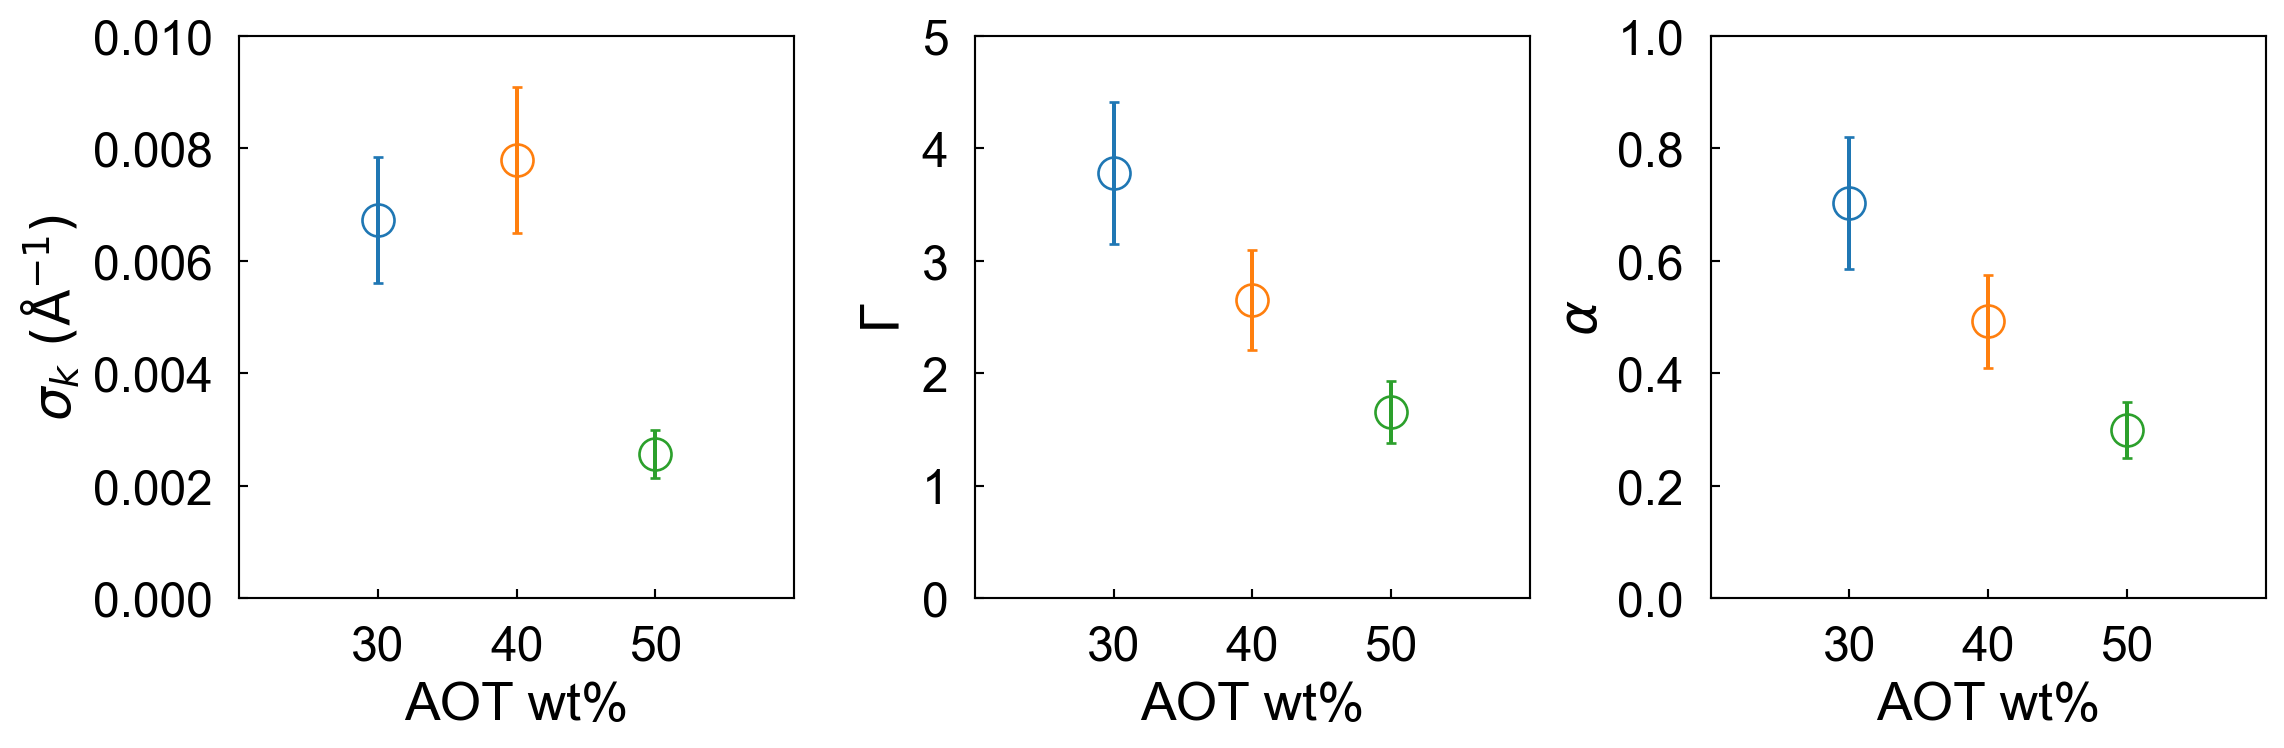

In [39]:
## plot fitting parameters
fig = plt.figure(figsize=(12,4),dpi=192)
ax = fig.add_subplot(1,3,1)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['sigma_k']/20
    y_er = std_list[index_data][0]/20

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\sigma_k\ (\mathrm{\AA}^{-1})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,0.01])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(1,3,2)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['kappa']
    y_er = std_list[index_data][1]

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\Gamma$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,5])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(1,3,3)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['alpha']
    y_er = std_list[index_data][2]

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\alpha$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,1])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()


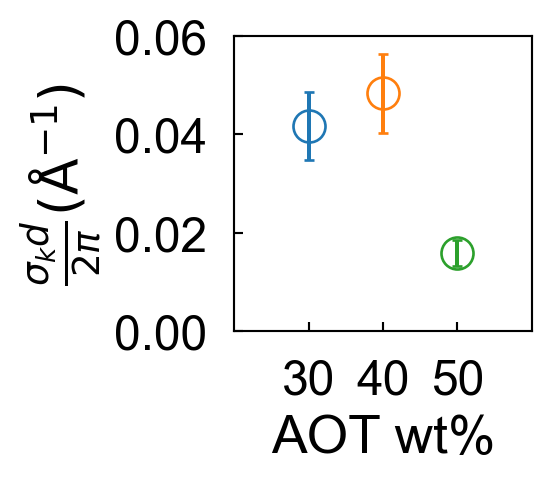

In [36]:
fig = plt.figure(figsize=(2,2),dpi=192)
ax = fig.add_subplot(1,1,1)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['sigma_k']/20*d_max/2/np.pi
    y_er = std_list[index_data][0]/20*d_max/2/np.pi

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\frac{\sigma_k d}{2\pi} (\mathrm{\AA}^{-1})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,0.06])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

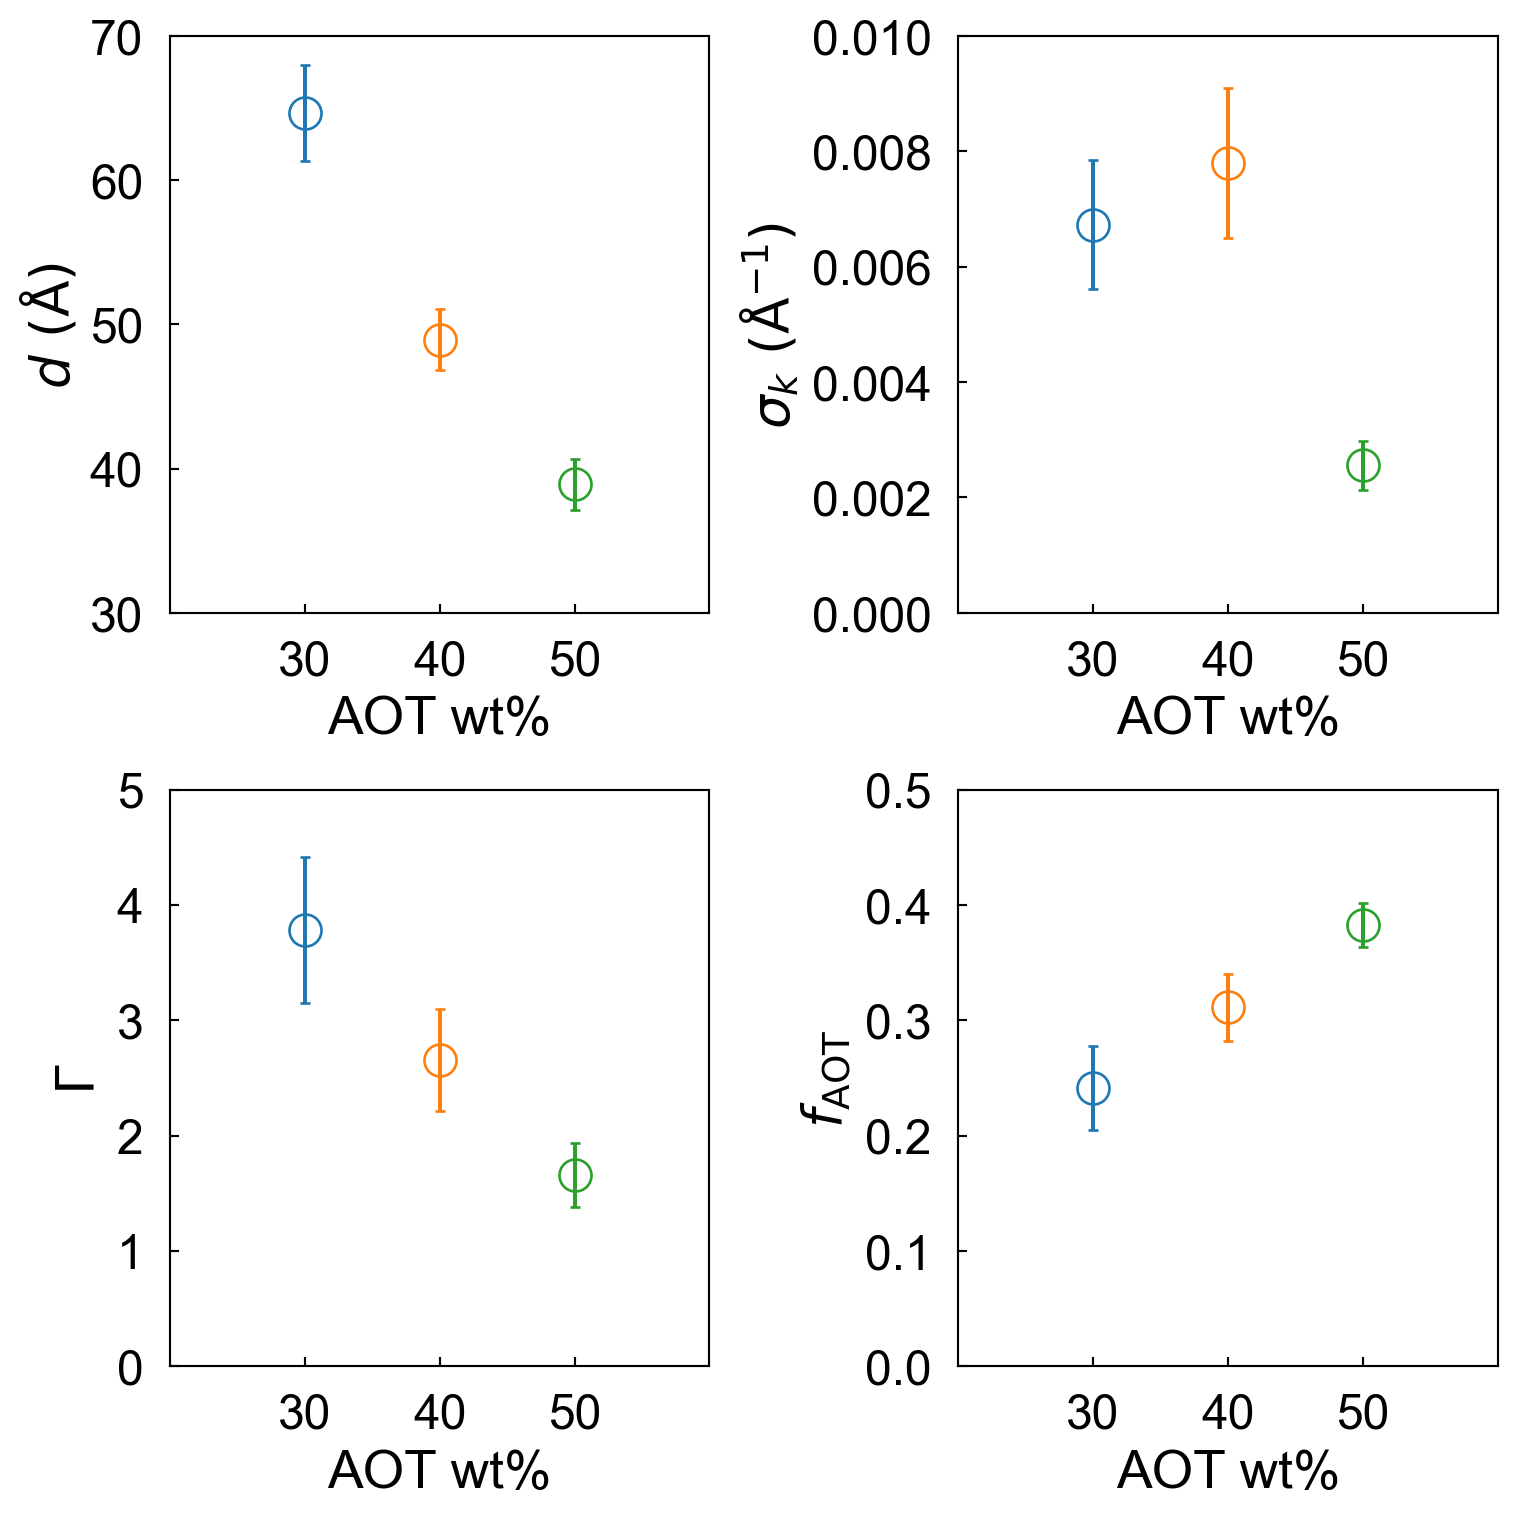

In [26]:
## plot fitting parameters
fig = plt.figure(figsize=(8,8),dpi=192)
ax = fig.add_subplot(2,2,1)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    y = d_max
    y_er = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$d\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([30,70])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(2,2,2)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['sigma_k']/20
    y_er = std_list[index_data][0]/20

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\sigma_k\ (\mathrm{\AA}^{-1})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,0.01])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(2,2,3)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['kappa']
    y_er = std_list[index_data][1]

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\Gamma$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,5])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# ax = fig.add_subplot(2,2,3)
# for index_data in range(3):
#     result = result_list[index_data]
#     v_res = result.params.valuesdict()
#     x = W_list[index_data]
#     y = v_res['alpha']
#     y_er = std_list[index_data][2]

#     ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
#     ax.errorbar(x,y,y_er,
#                 linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
# ax.set_xticks([30,40,50])
# ax.set_xlabel(r'AOT wt%',fontsize=20)
# ax.set_ylabel(r'$\alpha$',fontsize=20)
# # ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_xlim([20,60])
# ax.set_ylim([0,1])
# ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(2,2,4)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = volume_fraction(v_res['alpha'])
    y_er = volume_fraction_err(v_res['alpha'],std_list[index_data][2])

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$f_\mathrm{AOT}$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,0.5])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

In [4]:
def std_phi(kappa):
    xi_list = np.linspace(1/10000,1,10000)
    W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
    phi = np.arccos(W)
    sigma = np.sqrt(np.sum(phi**2*np.sin(phi))/np.sum(np.sin(phi)))/np.pi*180
    return sigma

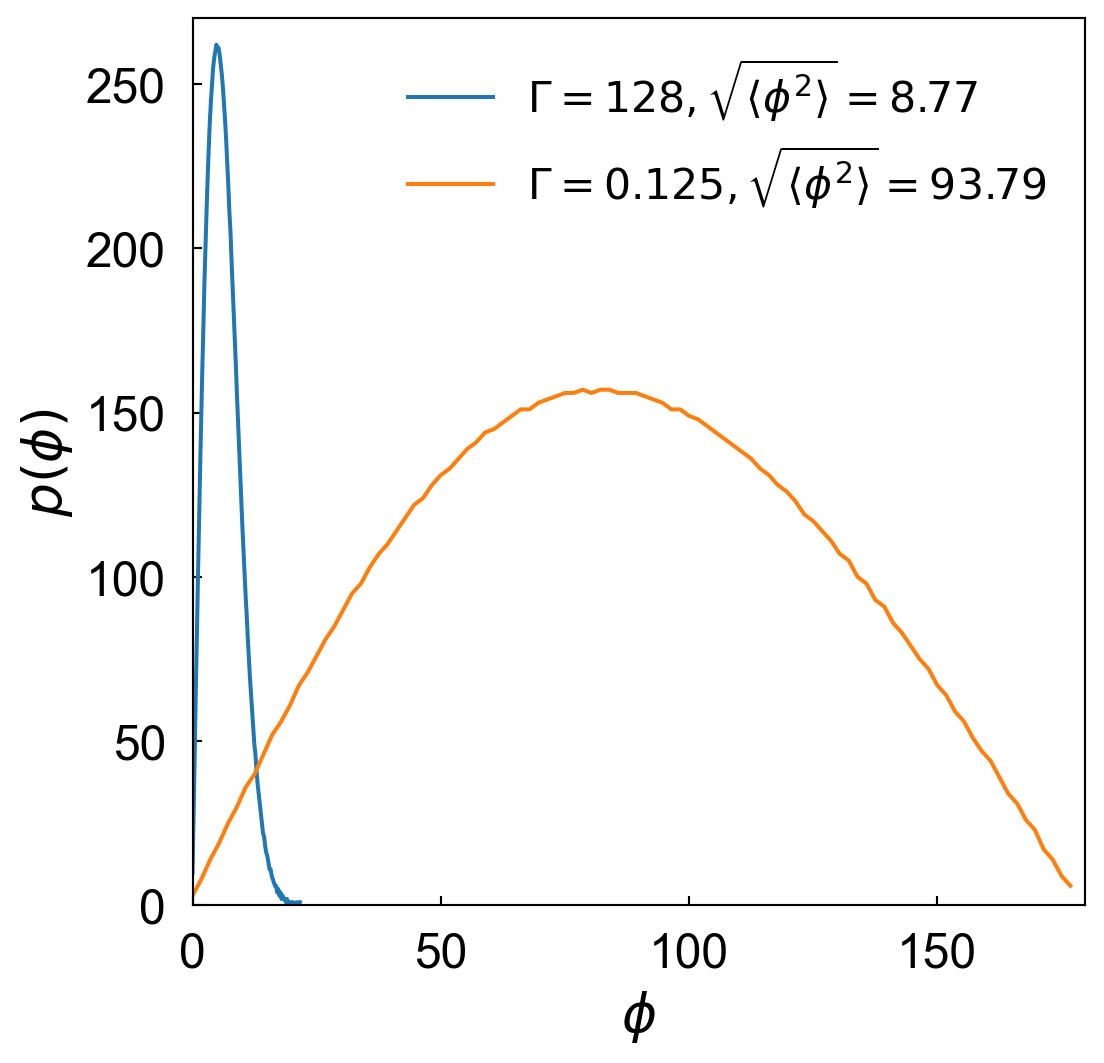

In [60]:
fig = plt.figure(figsize=(6,6),dpi=192)
ax = fig.add_subplot(1,1,1)

kappa = 128
xi_list = np.linspace(1/10000,1,10000)
W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
phi = np.arccos(W)

bins = 100
range = [0,np.pi]
hist_1, bins_1 = np.histogram(phi,bins=bins)
ax.plot(bins_1[:-1]/np.pi*180,hist_1,label = r'$\Gamma = {}, \sqrt{{\langle \phi^2 \rangle}} = {:0.2f} $'.format(kappa,std_phi(kappa)))

kappa = 1/8
xi_list = np.linspace(1/10000,1,10000)
W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
phi = np.arccos(W)

bins = 100
range = [0,np.pi]
hist_2, bins_2 = np.histogram(phi,bins=bins)
ax.plot(bins_2[:-1]/np.pi*180,hist_2,label = r'$\Gamma = {}, \sqrt{{\langle \phi^2 \rangle}}  = {:0.2f} $'.format(kappa,std_phi(kappa)))

ax.set_xlim([0,180])
ax.set_ylim([0,270])

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_ylabel(r'$p(\phi)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax.legend(frameon=False, fontsize=16)


51.55341049778064
60.50384131555297
71.55786757506972


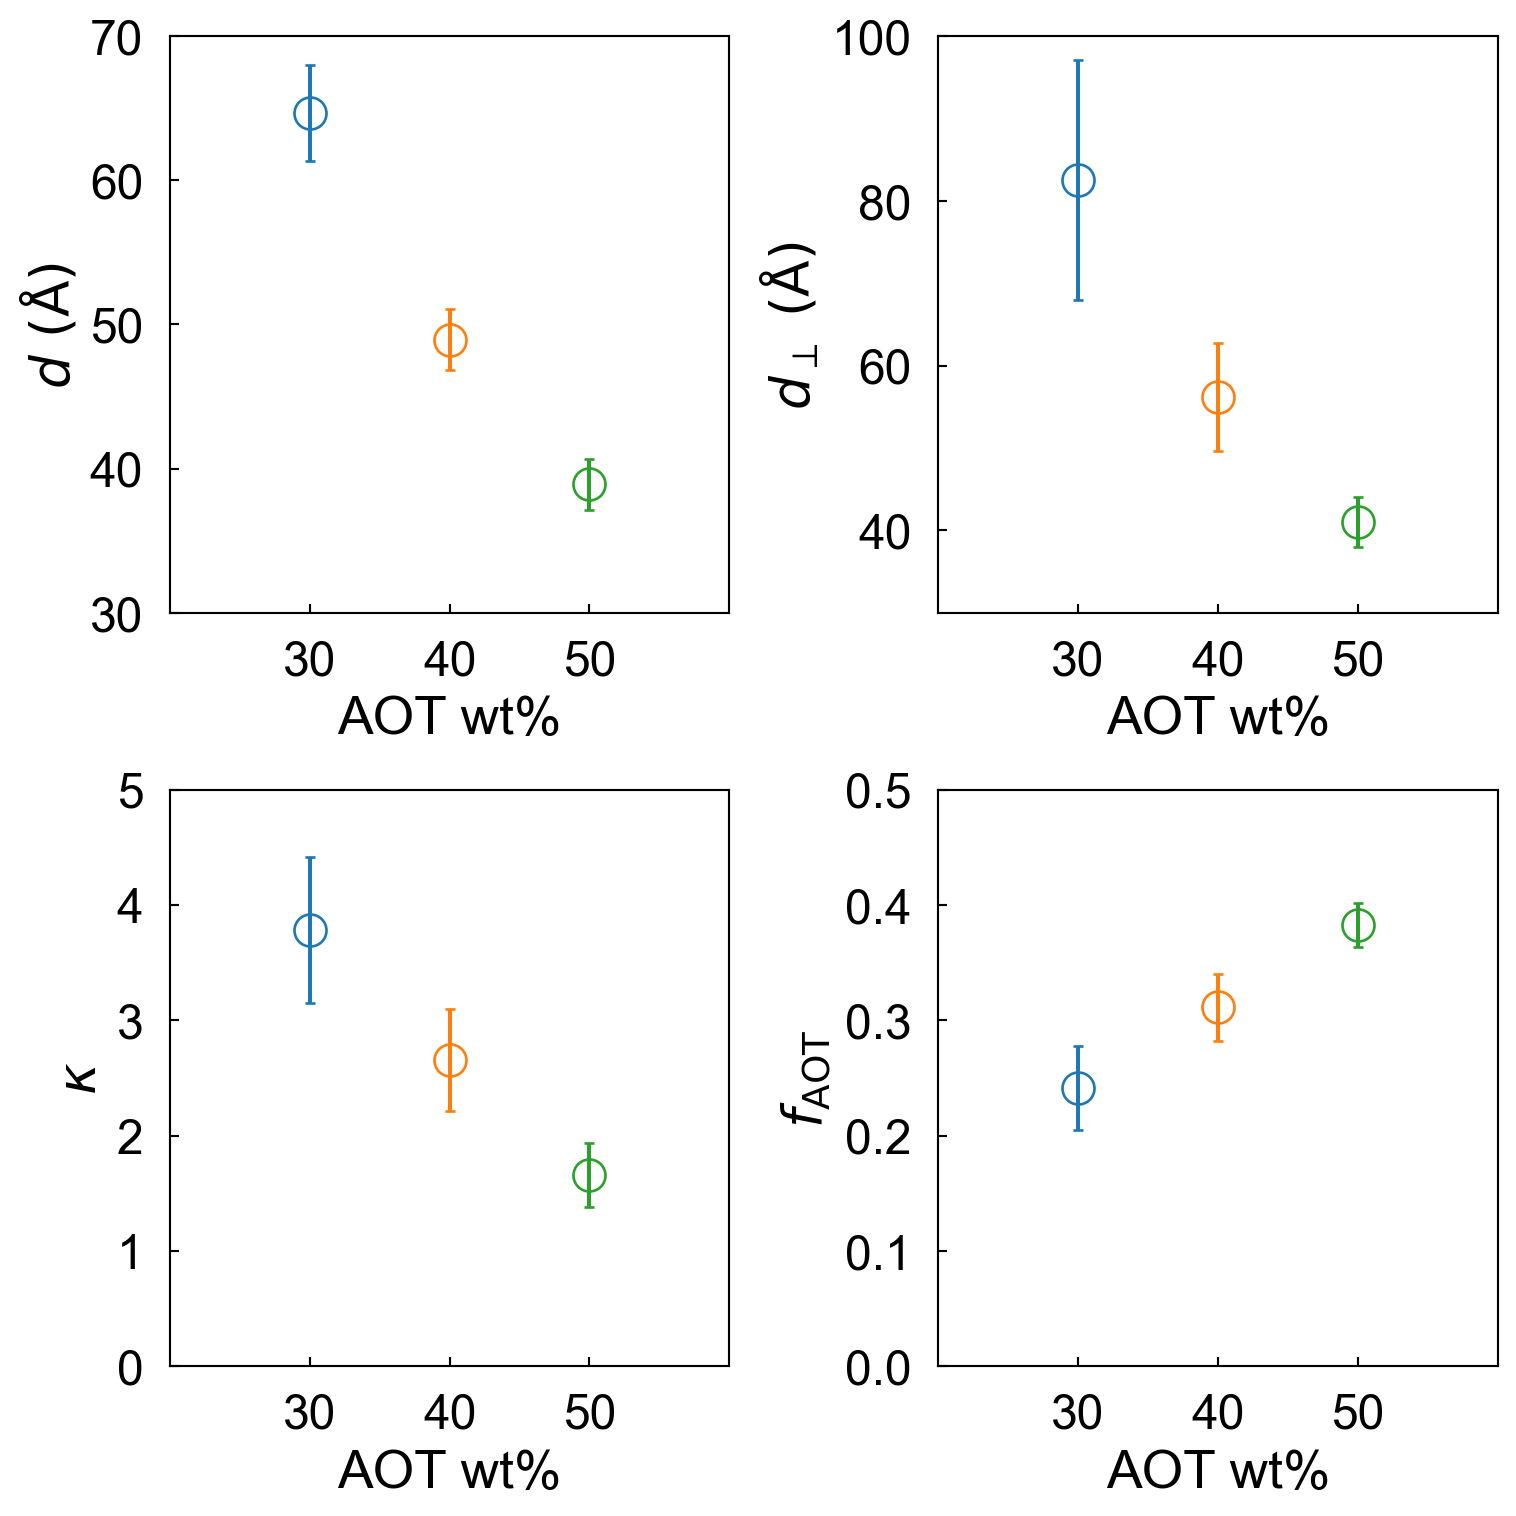

In [32]:
## plot fitting parameters
fig = plt.figure(figsize=(8,8),dpi=192)
ax = fig.add_subplot(2,2,1)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    y = d_max
    y_er = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$d\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([30,70])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(2,2,2)
# ax.plot([0,100],[0,100],'-k')
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    x = W_list[index_data]
    # x = d_max
    kappa = v_res['kappa']
    kappa_er = std_list[index_data][1]
    print(std_phi(kappa))
    std_phi_kappa = std_phi(kappa)*np.pi/180
    y = d_max/np.sin(std_phi_kappa)
    y_er1 = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])/np.sin(std_phi_kappa)
    y_er2 = d_max/np.sin(std_phi_kappa)/(-np.tan(std_phi_kappa)*np.sin(std_phi_kappa))*(kappa_er/kappa)
    y_er = np.sqrt(y_er1**2+y_er2**2)

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
# ax.set_xticks([0,25,50,75,100])
# ax.set_yticks([0,25,50,75,100])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$d_{\perp}\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([30,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(2,2,3)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = v_res['kappa']
    y_er = std_list[index_data][1]

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$\kappa$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,5])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# ax = fig.add_subplot(2,2,3)
# for index_data in range(3):
#     result = result_list[index_data]
#     v_res = result.params.valuesdict()
#     x = W_list[index_data]
#     y = v_res['alpha']
#     y_er = std_list[index_data][2]

#     ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
#     ax.errorbar(x,y,y_er,
#                 linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
# ax.set_xticks([30,40,50])
# ax.set_xlabel(r'AOT wt%',fontsize=20)
# ax.set_ylabel(r'$\alpha$',fontsize=20)
# # ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_xlim([20,60])
# ax.set_ylim([0,1])
# ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(2,2,4)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    y = volume_fraction(v_res['alpha'])
    y_er = volume_fraction_err(v_res['alpha'],std_list[index_data][2])

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$f_\mathrm{AOT}$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([0,0.5])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

51.55341049778064
60.50384131555297
71.55786757506972


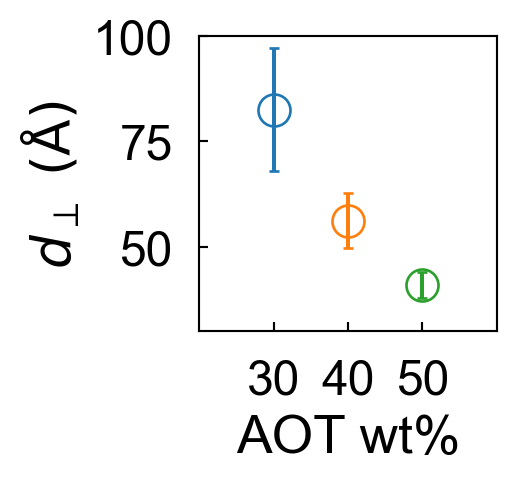

In [27]:
fig = plt.figure(figsize=(2,2),dpi=192)
ax = fig.add_subplot(1,1,1)
# ax.plot([0,100],[0,100],'-k')
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    x = W_list[index_data]
    # x = d_max
    kappa = v_res['kappa']
    kappa_er = std_list[index_data][1]
    print(std_phi(kappa))
    std_phi_kappa = std_phi(kappa)*np.pi/180
    y = d_max/np.sin(std_phi_kappa)
    y_er1 = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])/np.sin(std_phi_kappa)
    y_er2 = d_max/np.sin(std_phi_kappa)/(-np.tan(std_phi_kappa)*np.sin(std_phi_kappa))*(kappa_er/kappa)
    y_er = np.sqrt(y_er1**2+y_er2**2)

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
# ax.set_xticks([0,25,50,75,100])
# ax.set_yticks([0,25,50,75,100])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$d_{\perp}\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([30,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

51.55341049778064
60.50384131555297
71.55786757506972
51.55341049778064
60.50384131555297
71.55786757506972


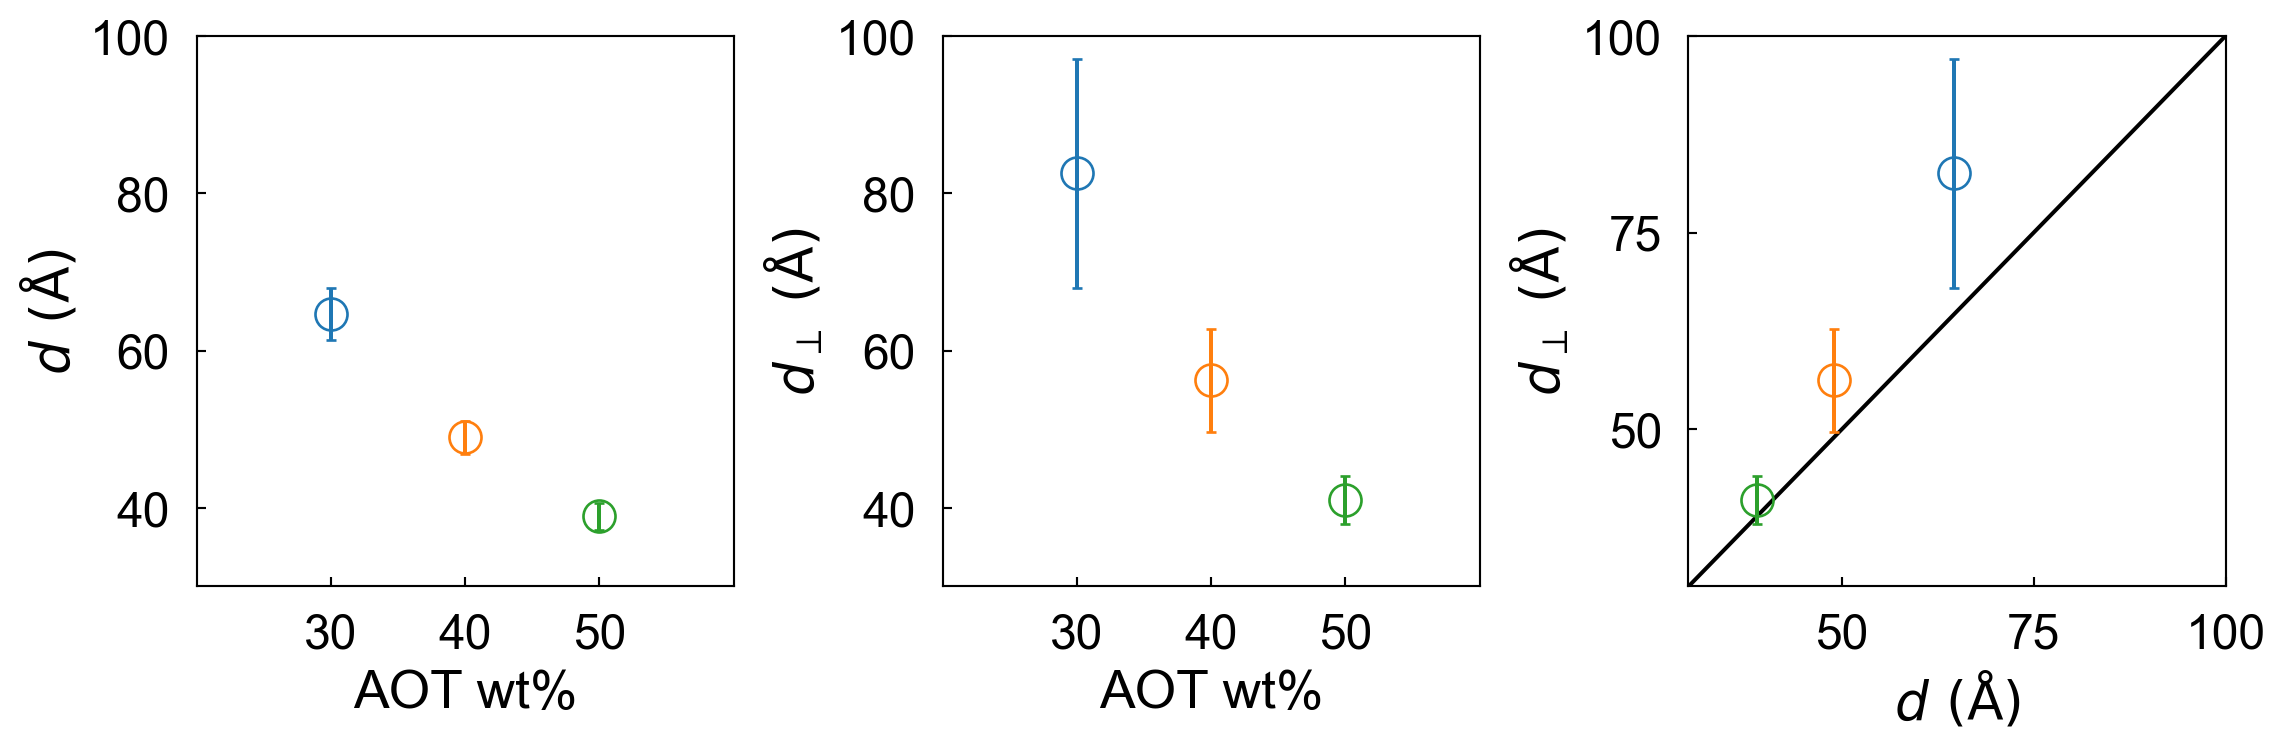

In [50]:
## plot fitting parameters
fig = plt.figure(figsize=(12,4),dpi=192)
ax = fig.add_subplot(1,3,1)
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    x = W_list[index_data]
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    y = d_max
    y_er = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$d\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([30,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(1,3,2)
# ax.plot([0,100],[0,100],'-k')
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    x = W_list[index_data]
    # x = d_max
    kappa = v_res['kappa']
    kappa_er = std_list[index_data][1]
    print(std_phi(kappa))
    std_phi_kappa = std_phi(kappa)*np.pi/180
    y = d_max/np.sin(std_phi_kappa)
    y_er1 = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])/np.sin(std_phi_kappa)
    y_er2 = d_max/np.sin(std_phi_kappa)/(-np.tan(std_phi_kappa)*np.sin(std_phi_kappa))*(kappa_er/kappa)
    y_er = np.sqrt(y_er1**2+y_er2**2)

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
ax.set_xticks([30,40,50])
# ax.set_xticks([0,25,50,75,100])
# ax.set_yticks([0,25,50,75,100])
ax.set_xlabel(r'AOT wt%',fontsize=20)
ax.set_ylabel(r'$d_{\perp}\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([20,60])
ax.set_ylim([30,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(1,3,3)
ax.plot([0,100],[0,100],'-k')
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    # x = W_list[index_data]
    x = d_max
    kappa = v_res['kappa']
    kappa_er = std_list[index_data][1]
    print(std_phi(kappa))
    std_phi_kappa = std_phi(kappa)*np.pi/180
    y = d_max/np.sin(std_phi_kappa)
    y_er1 = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])/np.sin(std_phi_kappa)
    y_er2 = d_max/np.sin(std_phi_kappa)/(-np.tan(std_phi_kappa)*np.sin(std_phi_kappa))*(kappa_er/kappa)
    y_er = np.sqrt(y_er1**2+y_er2**2)

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
# ax.set_xticks([30,40,50])
ax.set_xticks([0,25,50,75,100])
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel(r'$d\ (\mathrm{\AA})$',fontsize=20)
ax.set_ylabel(r'$d_{\perp}\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([30,100])
ax.set_ylim([30,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

51.55341049778064
60.50384131555297
71.55786757506972


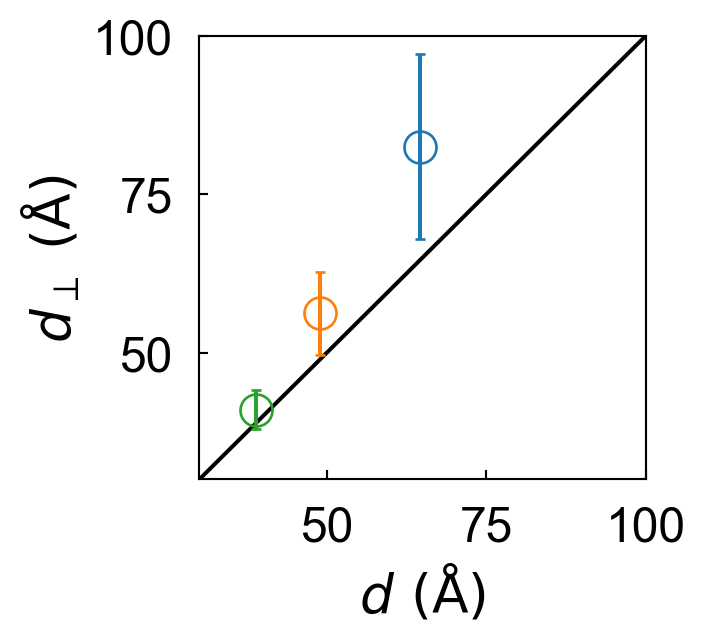

In [46]:
fig = plt.figure(figsize=(3,3),dpi=192)
ax = fig.add_subplot(1,1,1)
ax.plot([0,100],[0,100],'-k')
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    # x = W_list[index_data]
    x = d_max
    kappa = v_res['kappa']
    kappa_er = std_list[index_data][1]
    print(std_phi(kappa))
    std_phi_kappa = std_phi(kappa)*np.pi/180
    y = d_max/np.sin(std_phi_kappa)
    y_er1 = d_max*delta_Q_list[index_data]/(Q_max_list[index_data])/np.sin(std_phi_kappa)
    y_er2 = d_max/np.sin(std_phi_kappa)/(-np.tan(std_phi_kappa)*np.sin(std_phi_kappa))*(kappa_er/kappa)
    y_er = np.sqrt(y_er1**2+y_er2**2)

    ax.plot(x,y,'o',fillstyle='none',ms=12, color = color_list[index_data])
    ax.errorbar(x,y,y_er,
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2)
# ax.set_xticks([30,40,50])
ax.set_xticks([0,25,50,75,100])
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel(r'$d\ (\mathrm{\AA})$',fontsize=20)
ax.set_ylabel(r'$d_{\perp}\ (\mathrm{\AA})$',fontsize=20)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([30,100])
ax.set_ylim([30,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)



## visualize the real space image

In [28]:
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    clip_random_wave(v_res, W=W_list[index_data])

Widget(value="<iframe src='http://localhost:57798/index.html?ui=P_0x24b52330ac0_0&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:57798/index.html?ui=P_0x24911cca7f0_1&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:57798/index.html?ui=P_0x24b68e96e80_2&reconnect=auto' style='width…

Computing Curvature: 100%|██████████[00:00<00:00]
Computing Curvature: 100%|██████████[00:00<00:00]
Computing Curvature: 100%|██████████[00:00<00:00]
Computing Curvature: 100%|██████████[00:00<00:00]
Computing Curvature: 100%|██████████[00:00<00:00]
Computing Curvature: 100%|██████████[00:00<00:00]


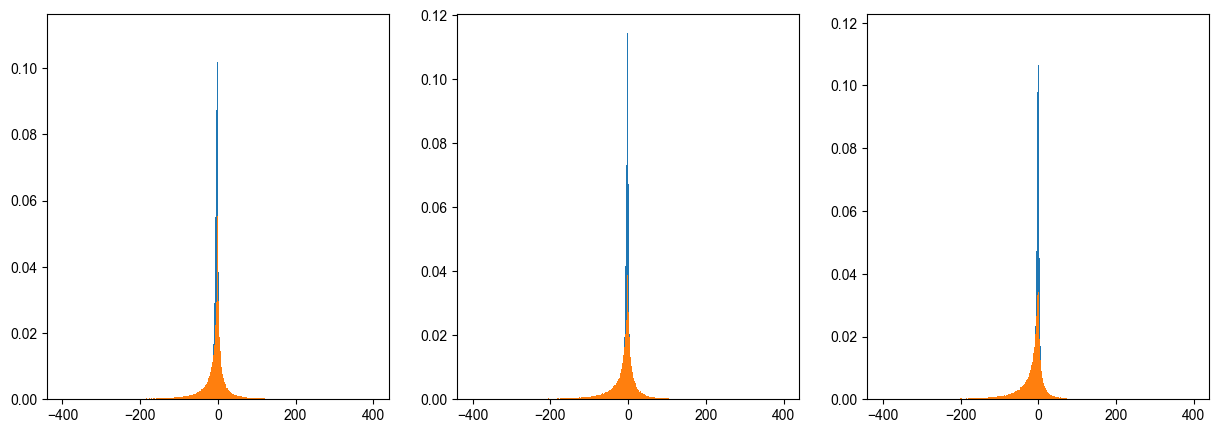

In [29]:
fig = plt.figure(figsize=(15,5))
MC_hist_list = []
GC_hist_list = []
for index_data in range(3):
    result = result_list[index_data]
    v_res = result.params.valuesdict()
    MC, GC, cell_sizes = curvature(v_res, W=W_list[index_data])

    ax = fig.add_subplot(1,3,index_data+1)

    bins_MC = np.linspace(-60,60,301)
    bins_GC = np.linspace(-400,400,801)

    MC_hist = ax.hist(MC,bins=bins_MC,density=True)
    GC_hist = ax.hist(GC,bins=bins_GC,density=True)

    MC_hist_list.append(MC_hist)
    GC_hist_list.append(GC_hist)

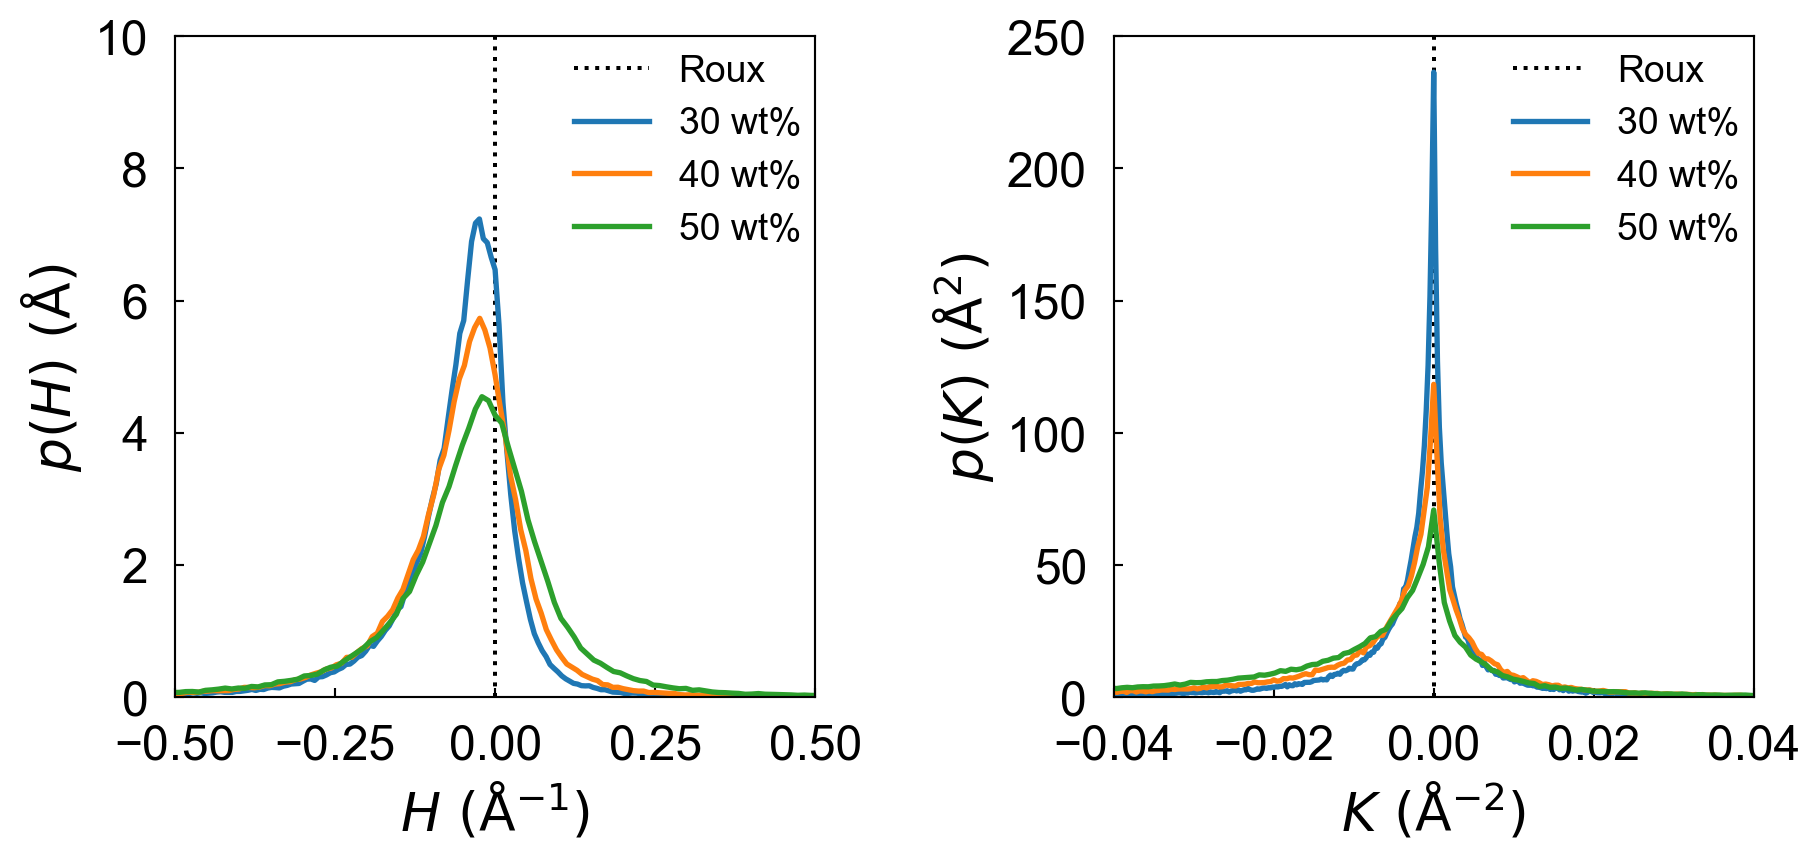

In [30]:
fig = plt.figure(figsize=(10,5),dpi=192)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot([0,0],[0,10],':k', label = 'Roux')
ax2.plot([0,0],[0,250],':k', label = 'Roux')

for index_data in range(3):
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    
    ax1.plot(bins_MC[1:]/d_max,MC_hist_list[index_data][0]*d_max,
             '-',color = color_list[index_data],lw=2,
             label = '{:d} wt%'.format(W_list[index_data]))

    ax1.set_xlim([-0.5,0.5])
    ax1.set_ylim([0.0,10])

    ax1.set_xlabel(r'$H\ (\mathrm{\AA^{-1}})$',fontsize=20)
    ax1.set_ylabel(r'$p(H)\ (\mathrm{\AA})$',fontsize=20)
    ax1.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    # ax.set_yscale('log')
    # ax.set_aspect(6/1)

    ax2.plot(bins_GC[1:]/d_max**2,GC_hist_list[index_data][0]*d_max**2,
            '-', color = color_list[index_data],lw=2, 
            label = '{:d} wt%'.format(W_list[index_data]))

    ax2.set_xlim([-0.04,0.04])
    ax2.set_ylim([0.0,250])

    ax2.set_xlabel(r'$K\ (\mathrm{\AA^{-2}})$',fontsize=20)
    ax2.set_ylabel(r'$p(K)\ (\mathrm{\AA}^{2})$',fontsize=20)
    ax2.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    # ax.set_yscale('log')
    # ax.set_aspect(6/1)

ax1.legend(frameon=False, fontsize=14, loc=[0.6,0.66])
ax2.legend(frameon=False, fontsize=14, loc=[0.6,0.66])
plt.tight_layout(pad=2.6)

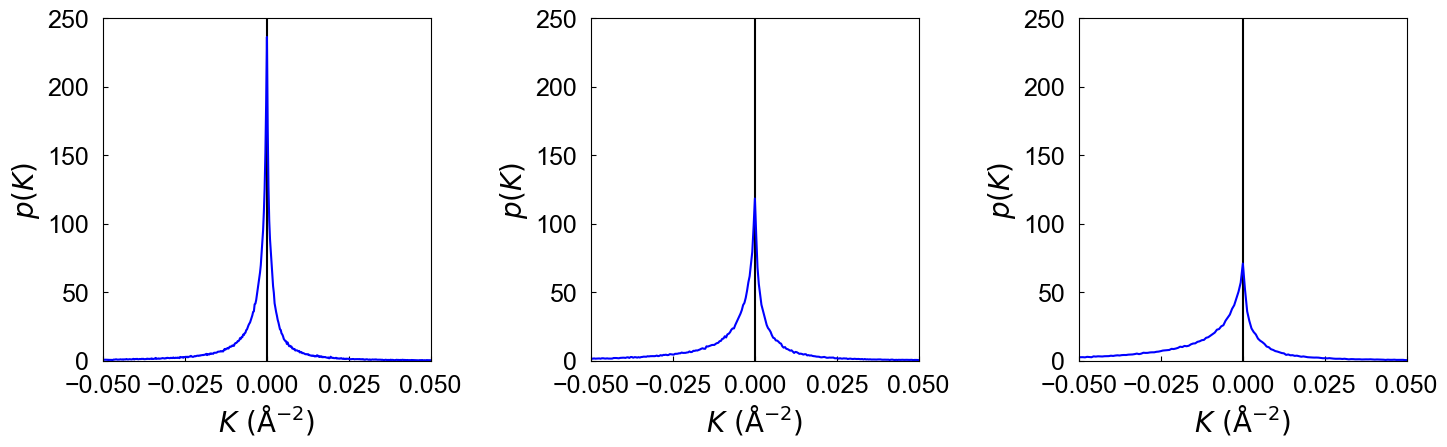

In [31]:
fig = plt.figure(figsize=(15,5))
for index_data in range(3):
    d_max = 2*np.pi/(Q_max_list[index_data]*v_res['x_scale'])
    ax = fig.add_subplot(1,3,index_data+1)

    ax.plot([0,0],[0,250],'-k')
    ax.plot(bins_GC[1:]/d_max**2,GC_hist_list[index_data][0]*d_max**2,'-b')

    ax.set_xlim([-0.05,0.05])
    ax.set_ylim([0.0,250])

    ax.set_xlabel(r'$K\ (\mathrm{\AA^{-2}})$',fontsize=20)
    ax.set_ylabel(r'$p(K)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    # ax.set_yscale('log')
    # ax.set_aspect(6/1)

plt.tight_layout(pad=2.6)